In [115]:
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
import datetime as dt

In [80]:
user = pd.read_csv('user_table.csv')
home = pd.read_csv('home_page_table.csv')
search = pd.read_csv('search_page_table.csv')
payment = pd.read_csv('payment_page_table.csv')
payment_confirm = pd.read_csv('payment_confirmation_table.csv')


In [81]:
home = home.rename(columns={'page':'home_page'})
search = search.rename(columns={'page':'search_page'})
payment = payment.rename(columns={'page':'payment_page'})
payment_confirm = payment_confirm.rename(columns={'page':'payment_confirmation_page'})

In [82]:
data_frames = [user, home, search, payment, payment_confirm]
df_merge = reduce(lambda  left,right: pd.merge(left,right,on=['user_id'], how='left'), data_frames)
df_desktop = df_merge[df_merge['device']=='Desktop'].reset_index(drop=True)
df_mobile = df_merge[df_merge['device']=='Mobile'].reset_index(drop=True)

In [111]:
df_merge.head(5)

,user_id,date,device,sex,home_page,search_page,payment_page,payment_confirmation_page
0,450007,2015-02-28,Desktop,Female,home_page,NaN,NaN,NaN
1,756838,2015-01-13,Desktop,Male,home_page,NaN,NaN,NaN
2,568983,2015-04-09,Desktop,Male,home_page,search_page,NaN,NaN
3,190794,2015-02-18,Desktop,Female,home_page,search_page,NaN,NaN
4,537909,2015-01-15,Desktop,Male,home_page,NaN,NaN,NaN


In [89]:
conv_all = 1 - pd.DataFrame(df_merge.isnull().sum()).rename(columns={0: 'probability'}) / len(df_merge)
conv_all = conv_all.reset_index()[4:]
conv_all.reset_index(drop=True)

,index,probability
0,home_page,1.000000
1,search_page,0.500000
2,payment_page,0.066704
3,payment_confirmation_page,0.005000


### Conversion Rate for Device

In [92]:
def conversion(df):
    conv_list = []
    conv_list.append(1)
    conv = len(df[df['search_page'].notnull()])/len(df[df['home_page'].notnull()])
    conv_list.append(conv)
    conv = len(df[df['payment_page'].notnull()])/len(df[df['search_page'].notnull()])
    conv_list.append(conv)
    conv = len(df[df['payment_confirmation_page'].notnull()])/len(df[df['payment_page'].notnull()])
    conv_list.append(conv)
    return conv_list

In [109]:
conv_all = conversion(df_merge)
conv_desktop = conversion(df_desktop)
conv_mobile = conversion(df_mobile)
names = ['home','search', 'payment','confirmation']
maps = {'Page': names, 'conv_overall': conv_all, 'conv_desktop': conv_desktop, 'conv_mobile': conv_mobile}
df = pd.DataFrame.from_dict(maps)
df

,Page,conv_overall,conv_desktop,conv_mobile
0,home,1.000000,1.000000,1.0
1,search,0.500000,0.500000,0.5
2,payment,0.133407,0.100000,0.2
3,confirmation,0.074959,0.049834,0.1


Text(0, 0.5, 'Rate')

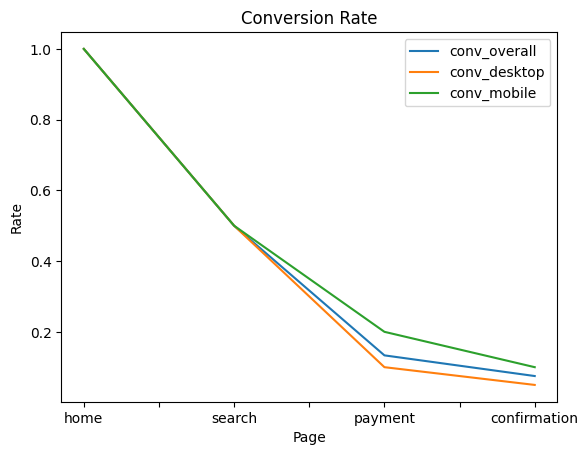

In [108]:
df.set_index('Page', inplace=True)

df.plot(kind='line')
plt.title('Conversion Rate')
plt.xlabel('Page')
plt.ylabel('Rate')

For now, there are few findings
- The conversion rate from the search page to the payment page experiences the most significant drop.
- On mobile devices, the conversion rate from the search page to the payment page is notably lower.

### Conversion Rate for Sex

In [112]:
df_male = df_merge[df_merge['sex']=='Male'].reset_index(drop=True)
df_female = df_merge[df_merge['sex']=='Female'].reset_index(drop=True)

In [113]:
conv_all = conversion(df_merge)
conv_male = conversion(df_male)
conv_female = conversion(df_female)
names = ['home','search', 'payment','confirmation']
maps = {'Page': names, 'conv_overall': conv_all, 'conv_male': conv_male, 'conv_female': conv_female}
df_sex = pd.DataFrame.from_dict(maps)
df_sex

,Page,conv_overall,conv_male,conv_female
0,home,1.000000,1.000000,1.000000
1,search,0.500000,0.496944,0.503073
2,payment,0.133407,0.130083,0.136708
3,confirmation,0.074959,0.072014,0.077742


Text(0, 0.5, 'Rate')

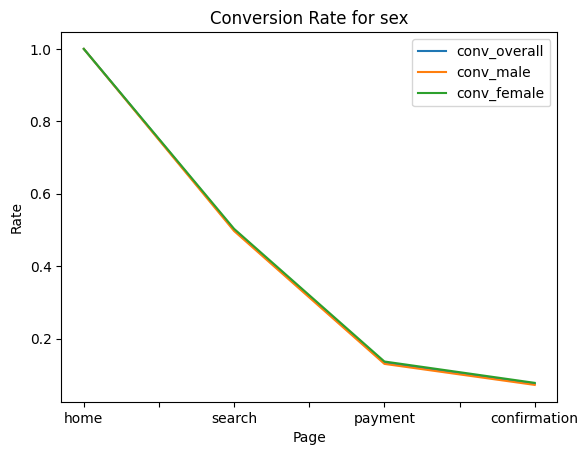

In [114]:
df_sex.set_index('Page', inplace=True)

df_sex.plot(kind='line')
plt.title('Conversion Rate for sex')
plt.xlabel('Page')
plt.ylabel('Rate')

### Conversion Rate for Date

In [124]:
df_merge['date'] = pd.to_datetime(df_merge['date'])
df_merge['year'] = df_merge['date'].dt.year
df_merge['month'] = df_merge['date'].dt.month
df_merge['weekday'] = df_merge['date'].dt.weekday
print(df_merge['year'].unique())
print(df_merge['month'].unique())
print(df_merge['weekday'].unique())

[2015]
[2 1 4 3]
[5 1 3 2 6 0 4]


In [144]:
df_month = df_merge[['month','home_page','search_page','payment_page','payment_confirmation_page']].groupby(['month']).count()
df_month

,home_page,search_page,payment_page,payment_confirmation_page
month,,,,
1,22600,13554,2390,189
2,22600,13687,2412,173
3,22600,8879,631,44
4,22600,9080,597,46


In [148]:
df_weekday = df_merge[['weekday','home_page','search_page','payment_page','payment_confirmation_page']].groupby(['weekday']).count()
df_weekday

,home_page,search_page,payment_page,payment_confirmation_page
weekday,,,,
0,12955,6483,869,77
1,12697,6252,853,69
2,12831,6335,838,54
3,13444,6717,899,66
4,12750,6406,871,54
5,12801,6545,845,70
6,12922,6462,855,62


In [149]:
def calculate(df):
    df['home'] = 1
    df['search'] = df['search_page'] / df['home_page']
    df['payment'] = df['payment_page'] / df['search_page']
    df['confirmation'] = df['payment_confirmation_page'] / df['payment_page']
    return df

In [150]:
month = calculate(df_month)
month = month[['home','search', 'payment','confirmation']]
month = month.T

weekday = calculate(df_weekday)
weekday = weekday[['home','search', 'payment','confirmation']]
weekday = weekday.T
weekday

weekday,0,1,2,3,4,5,6
home,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
search,0.500425,0.492400,0.493726,0.499628,0.502431,0.511288,0.500077
payment,0.134043,0.136436,0.132281,0.133840,0.135966,0.129106,0.132312
confirmation,0.088608,0.080891,0.064439,0.073415,0.061998,0.082840,0.072515


Text(0, 0.5, 'Rate')

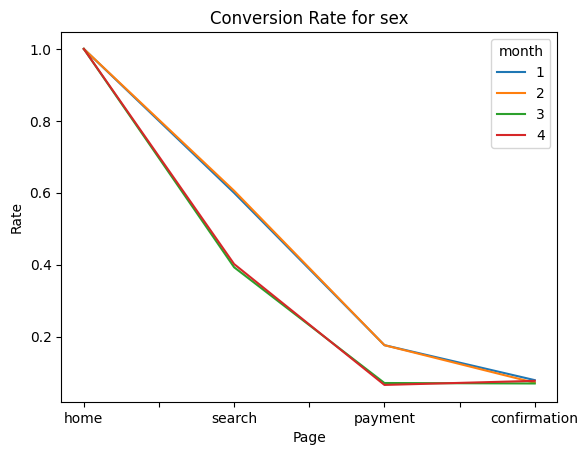

In [151]:
month.plot(kind='line')
plt.title('Conversion Rate for sex')
plt.xlabel('Page')
plt.ylabel('Rate')

Text(0, 0.5, 'Rate')

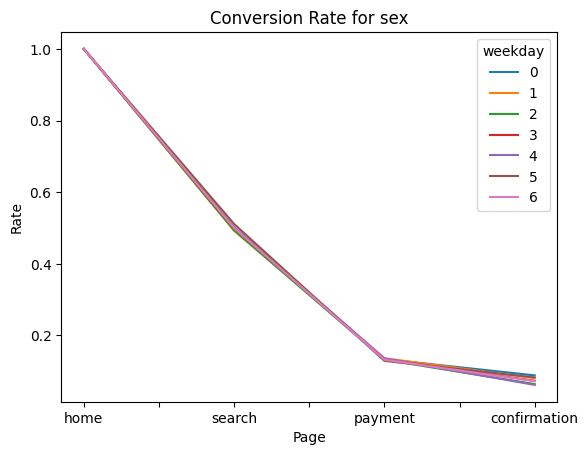

In [152]:
weekday.plot(kind='line')
plt.title('Conversion Rate for sex')
plt.xlabel('Page')
plt.ylabel('Rate')